# Lagged correlation of AMOC and NEMO variables

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal
import seaborn as sns
import string
from scipy.interpolate import griddata

In [8]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

In [9]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [10]:
from dask.distributed import Client, LocalCluster, wait

In [11]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44529 instead
  expected, actual


In [12]:
client

Client Scheduler: tcp://127.0.0.1:44741 Dashboard: http://127.0.0.1:44529/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [13]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [14]:
# NEMO mesh file has "z" as vertical coordinate
# but the grid_T files have "deptht" so we need to rename
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_tlon = ds_mesh['glamt'].sel(t=0)
da_orca05_tlat = ds_mesh['gphit'].sel(t=0)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_varea = (ds_mesh['e1t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'depthv'})
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_t = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})
da_orca05_mask_v = ds_mesh['vmask'].sel(t=0).rename({'z':'depthv'})

## Read NEMO stream functions

In [15]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [16]:
# NEMO MOC
ds_moc_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc


In [17]:
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [18]:
ds_moc

<xarray.Dataset>
Dimensions:    (time: 25200, y: 511, x: 1, depthw: 46)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
    lat        (y) float32 -76.95 -76.84 -76.73 -76.61 ... 89.79 89.94 89.79
Dimensions without coordinates: y, x
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

## Read NEMO data

Read in monthly in case we want to look at seasonal variables

In [13]:
# NEMO 3D monthly
ds_oce_1m_all = []

for exp,time in zip(exp_list,time_list):
    oce = '%s/%s/outdata/nemo/%s*1m*grid_T.nc' % (esmdir,exp,exp)
    print(oce)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_oce = xr.open_mfdataset(oce,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_oce_1m_all.append(ds_oce)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/FOCI_GJK001*1m*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/FOCI_GJK006*1m*grid_T.nc


In [14]:
ds_oce_1m = xr.concat( ds_oce_1m_all, dim='time' )

## Read NEMO data 

This has been remapped to 2x2 deg grid

In [19]:
# NEMO 3D annual 
ds_oce_1y_all = []

for exp,time in zip(exp_list,time_list):
    oce = '%s/%s/outdata/nemo/1y/r180x90/%s*1y*grid_T.nc' % (esmdir,exp,exp)
    print(oce)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_oce = xr.open_mfdataset(oce,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_oce_1y_all.append(ds_oce)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/1y/r180x90/FOCI_GJK001*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/1y/r180x90/FOCI_GJK006*1y*grid_T.nc


In [20]:
ds_oce_1y = xr.concat( ds_oce_1y_all, dim='time' )

In [21]:
ds_oce_1y

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, lon: 180, lat: 90, deptht: 46)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat                (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds
Data variables: (12/18)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    deptht_bnds        (time, deptht, bnds) float32 dask.array<chunksize=(10, 46, 2), meta=np.ndarray>
    votemper           (time, deptht, lat, lon) float32 dask.array<chunksize=(10, 46, 90, 180), meta=np.ndarray>
    vosaline           (time, deptht, lat, lon) float32 dask.array<chunksize=(10, 46, 90, 180), meta=np.ndarray>
    sosstsst           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sosaline           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    ...                 ...
    sohefldo           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    hflx_cal           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    somxl010           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    somixhgt           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sowindsp           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
    sobowlin           (time, lat, lon) float32 dask.array<chunksize=(10, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 18 20:50:16 2022: cdo -remapbil,r180x90 -setctomiss...
    name:         FOCI_GJK001_1m_18500101_18591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2021-Nov-12 19:21:54 GMT
    uuid:         928b9a2c-960f-4c37-b532-2f9456d34828
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [18]:
# NEMO 3D annual 
ds_gridv_1y_all = []

for exp,time in zip(exp_list,time_list):
    oce = '%s/%s/outdata/nemo/1y/%s*1y*grid_V.nc' % (esmdir,exp,exp)
    print(oce)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_oce = xr.open_mfdataset(oce,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_gridv_1y_all.append(ds_oce)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/1y/FOCI_GJK001*1y*grid_V.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/1y/FOCI_GJK006*1y*grid_V.nc


In [19]:
ds_gridv_1y = xr.concat( ds_gridv_1y_all, dim='time' )

## Read NEMO derived 

In [20]:
# NEMO heat content
ds_heatc_all = []

for exp,time in zip(exp_list,time_list):
    heatc = '%s/%s/outdata/nemo/cdf_analysis/%s*1m*heatc.nc' % (esmdir,exp,exp)
    print(heatc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_heatc = xr.open_mfdataset(heatc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_heatc_all.append(ds_heatc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*heatc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*heatc.nc


In [21]:
ds_heatc_1m = xr.concat( ds_heatc_all, dim='time' )

## Compute AMOC time series

In [16]:
# What latitude to use
amoc_lat = 26.5

# Latitudes from NEMO grid
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values

# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

# Take max stream function at specified latitude
# Then take annual means 
amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').groupby('time.year').mean('time').compute()
amoc_anom = amoc - amoc.mean('year')    

303 26.279882


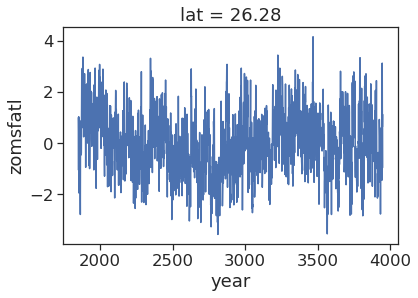

In [17]:
amoc_anom.plot()

## Define phases

In [18]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3199), slice(3200,3500)]

# New updated phases using 20-100 year bandpass
period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

## Lagged correlation of AMOC and OpenIFS variables

In [19]:
def lag_corr(x, y, shiftx=0, shifty=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    # Joakim: Assume we correlate AMOC and AMV. If positive AMOC anom
    # precedes positive AMV, then AMOC at year-shift is correlated with AMV at year
    # So correlation at lagx=-5 means x (AMOC) leads y (AMV). 
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = shiftx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean('time')
    ymean = y.mean('time')
    xstd  = x.std('time')
    ystd  = y.std('time')
    
    #4. Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum('time')/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [20]:
def manylags(x, data, lags):
    
    # Loop over the phases
    if 1:
        
        # List of all correlations
        da_r = []
        da_p = []
        da_k = []
        
        # Loop over lags
        # lag < 0 -> AMOC leads
        # lag > 0 -> AMOC lags
        for lagx in lags:
            
            # Detrend
            xd = detrend(x, dim='time')
            yd = detrend(data, dim='time')
            
            #if lagx == 0:
            #    # Control plot
            #    xd.plot(ax=ax1[jp], label='AMOC')
            #    yd.plot(ax=ax1[jp], label='AMV')
            
            # Linear regression
            _cov, _cor, _k, _m, _p, _std = lag_corr(xd, yd, shiftx=lagx)

            # Add lag as dimension and append to list
            _cor['lag'] = lagx
            _p['lag'] = lagx
            _k['lag'] = lagx
            da_r.append(_cor)
            da_p.append(_p)
            da_k.append(_k)
        
        # Merge along lag dimension
        cor = xr.concat(da_r,dim='lag')
        slope = xr.concat(da_k,dim='lag')
        pval = xr.concat(da_p,dim='lag')
        
    return cor, slope, pval

In [24]:
#variables = ['MLD','H700','Temp400','Vtransp360']
#variables = ['AMOC']
variables = ['MLD','Temp400','Salt400','SSS']
slope_list = []
cor_list = []

for v in variables:
    
    j = 1
    period = period_list[j]
    period_yr = period_list_yr[j]
    label = label_list[j]
    
    # Running mean
    runmean = 11
    
    if v == 'H700':
        # Heat content at 0-700m
        _da = ds_heatc_1m['voheatc'].sel(depthw=700,method='nearest').fillna(0)
        _da.name = 'h700'
        
    elif v == 'Temp400':
        _da = ds_oce_1y['votemper'].sel(deptht=400,method='nearest')
    
    elif v == 'Salt400':
        _da = ds_oce_1y['vosaline'].sel(deptht=400,method='nearest')
    
    elif v == 'SSS':
        _da = ds_oce_1y['vosaline'].sel(deptht=0,method='nearest')
        
    elif v == 'MLD':
        _da = ds_oce_1y['somxl010']
        
    elif v == 'Vtransp360':
        # y=360 is 48N on the ORCA05 grid (approx St Johns to Brest)
        # We multiply by dx * dz to get transport in Sv
        _da = (ds_gridv_1y['vomecrty'] * da_orca05_varea).isel(y=360) * 1e-6
    
    elif v == 'AMOC':
        _da = ds_moc['zomsfatl'].sel(x=0) # Atlantic overturning in Sv
    
    # Running mean
    #_amoc1 = amoc_anom.rolling(year=runmean,center=True).mean()
    #_da1 = _da.groupby('time.year').mean('time').rolling(year=runmean,center=True).mean()
    
    # We do time filter first, then select period
    # otherwise we would select a period of 250 years, 
    # then lose 100 years as nans due to filtering
    
    # Bandpass
    run1, run2 = 20,100
    _amoc1 = amoc_anom.rolling(year=run1,center=True).mean() - amoc_anom.rolling(year=run2,center=True).mean()
    _da1 = _da.groupby('time.year').mean('time').rolling(year=run1,center=True).mean() - \
           _da.groupby('time.year').mean('time').rolling(year=run2,center=True).mean()
    
    # Select period, rename year to time 
    _amoc = _amoc1.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
    _data = _da1.sel(year=period_yr).rename({'year':'time'}).dropna('time').compute()
    
    print('Variable: %s' % (v,))
    cor, slope, pval = manylags(_amoc, _data, lags=[-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30])
    
    cor.name = 'corr_AMOC26-%s' % (v,)
    slope.name = 'reg_AMOC26-%s' % (v,)
    ds_cor = cor.to_dataset()
    ds_slope = slope.to_dataset()
    _ds = xr.merge([ds_cor,ds_slope])
    _ds.to_netcdf('corr_AMOC26-%s_%s.nc' % (v,label_list[j]))
    
    cor_list.append(cor)
    slope_list.append(slope)

OSError: [Errno -51] NetCDF: Unknown file format: b'/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK006/outdata/nemo/1y/r180x90/FOCI_GJK006_1y_28500101_28591231_grid_T.nc'

In [ ]:
v = ds_gridv_1y['vomecrty']
dv = v * da_orca05_varea * 1e-6
dv.isel(time=2000,y=360).plot(vmin=-1e-1,vmax=1e-1,cmap=cmocean.cm.curl)
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim([468,570])

In [ ]:
def nemo2ll(data, nav_lon, nav_lat):
    
    # ORCA05 lon, lat (2d arrays)
    lon = nav_lon
    lat = nav_lat
    
    # Flatten lon, lat, MLD to 1d arrays
    # (treat this as unstructured grid)
    z1 = data.values.flatten()
    lon1 = lon.values.flatten()
    lat1 = lat.values.flatten()
    
    # Put lon lat into one array of size (npoints,2)
    points = np.vstack((lon1,lat1)).T
    
    # Take lon, lat from T2M data
    lon_r = np.arange(-180,180,2)
    lat_r = np.arange(-89,91,2)
    
    # Make 2D arrays using meshgrid
    lon_x, lat_y = np.meshgrid(lon_r,lat_r)
    
    # Interpolate using linear interp
    _data_i = griddata(points, z1, (lon_x, lat_y), method='linear')
    
    # Now make it into DataArray
    data_i = xr.DataArray(data=_data_i,
                          dims=["lat", "lon"],
                          coords=dict(
                              lon=(["lon"], lon_r),
                              lat=(["lat"], lat_r),)
                         )
    return data_i

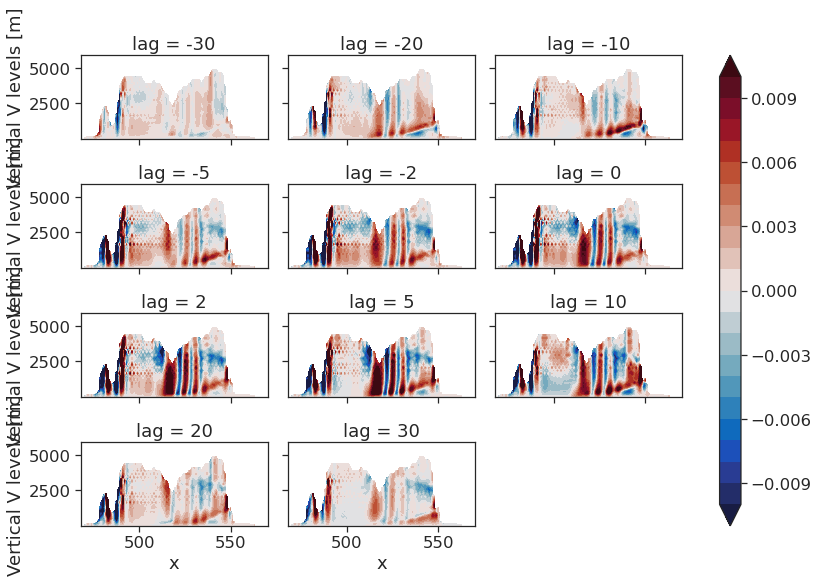

In [43]:
# Apply ORCA05 mask
_slope = slope_list[-1].where(da_orca05_mask_v.sel(y=360)==1)

p = _slope.plot.contourf(row='lag', col_wrap=3, cmap=cmocean.cm.balance, levels=np.linspace(-1e-2,1e-2,21), figsize=(12,8))

for ax in p.axes.flat:
    #ax.invert_yaxis()
    ax.set_xlim([468,570])
    
    #ax.set_ylim([253,508])
    

In [ ]:
slope_list[0].sel(lag=-30).plot()

## Plot on regular grid (takes time)

In [ ]:
fig1, ax1 = plt.subplots(11, 4, figsize=(14,30), 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]
for jv, (slope,cor,v) in enumerate( zip(slope_list[0:4], cor_list[0:4], variables[0:4]) ):
    
    if v == 'MLD':
        vmin = -100
        vmax = 100
    elif v == 'H700':
        vmin = -1000
        vmax = 1000
    elif v == 'Temp400':
        vmin = -0.5
        vmax = 0.5
    elif v == 'Salt400':
        vmin = -0.2
        vmax = 0.2
    elif v == 'SSS':
        vmin = -0.3
        vmax = 0.3
    
    print(v)
    for jl,l in enumerate(lags):
        
        ax = ax1[jl,jv]
        
        # select lag and interpolate to regular grid
        #slope_ll = nemo2ll(slope.sel(lag=l), da_orca05_tlon, da_orca05_tlat)
        
        cbar_kwargs={'shrink':0.8, 'label':''}
        
        #slope_ll.plot(ax=ax, vmin=vmin, vmax=vmax, 
        #              rasterized=True,
        #              cmap=cmocean.cm.balance,
        #              transform=ccrs.PlateCarree())
        slope.sel(lag=l).plot(ax=ax, vmin=vmin, vmax=vmax, 
                      rasterized=True,
                      cmap=cmocean.cm.balance,
                      cbar_kwargs=cbar_kwargs,
                      transform=ccrs.PlateCarree())            
        
        ax.set_title('%s, lag=%d' % (v,l))
        ax.coastlines()
        ax.set_extent([-100,40,0,90])
        #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
        #ax.axhline(y=48.5)
        
fig1.tight_layout()
#fig1.savefig('figures/AMOC45_MLD_H700_T400_Phase3_11yrlowpass.pdf',format='pdf')
fig1.savefig('figures/AMOC26_MLD_T400_S400_SSS_Phase2_20-100yrbandpass.pdf',dpi=150,format='pdf')

## Plot 

In [ ]:
fig1, ax1 = plt.subplots(11, 4, figsize=(14,30), 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]
for jv, (slope,cor,v) in enumerate( zip(slope_list[0:4], cor_list[0:4], variables[0:4]) ):
    
    if v == 'MLD':
        vmin = -100
        vmax = 100
    elif v == 'H700':
        vmin = -1000
        vmax = 1000
    elif v == 'Temp400':
        vmin = -0.5
        vmax = 0.5
    elif v == 'Salt400':
        vmin = -0.2
        vmax = 0.2
    elif v == 'SSS':
        vmin = -0.3
        vmax = 0.3
    
    print(v)
    for jl,l in enumerate(lags):
        
        ax = ax1[jl,jv]
        
        # select lag and interpolate to regular grid
        slope_ll = nemo2ll(slope.sel(lag=l), da_orca05_tlon, da_orca05_tlat)
        
        slope_ll.plot(ax=ax, vmin=vmin, vmax=vmax, 
                      rasterized=True,
                      cmap=cmocean.cm.balance,
                      transform=ccrs.PlateCarree())
        
        ax.set_title('%s, lag=%d' % (v,l))
        ax.coastlines()
        ax.set_extent([-100,40,0,90])
        #ax.set_extent([-180,180,40,90], crs=ccrs.PlateCarree())
        #ax.axhline(y=48.5)
        
fig1.tight_layout()
#fig1.savefig('figures/AMOC45_MLD_H700_T400_Phase3_11yrlowpass.pdf',format='pdf')
fig1.savefig('figures/AMOC26_MLD_T400_S400_SSS_Phase2_20-100yrbandpass.pdf',dpi=150,format='pdf')

## Plot regression for non-map variables

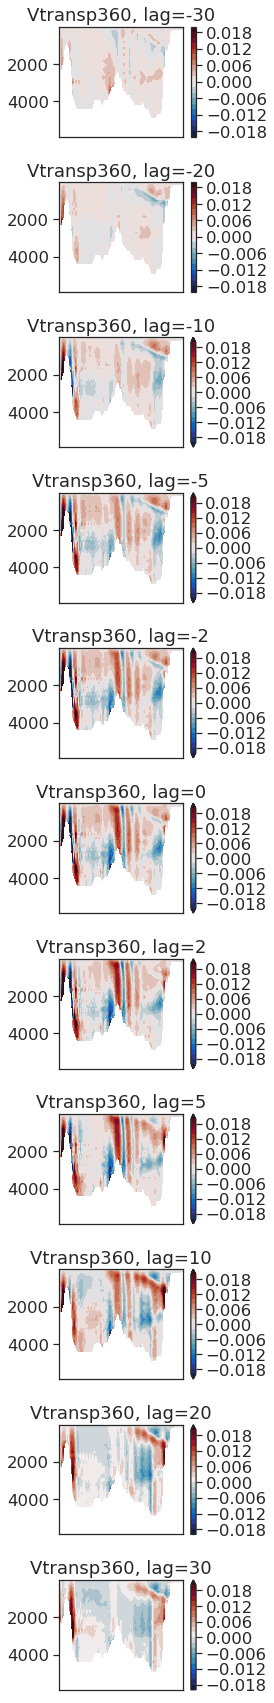

In [50]:
fig1, ax1 = plt.subplots(11, 1, figsize=(4,24))

lags = [-30, -20, -10, -5, -2, 0, 2, 5, 10, 20, 30]

for jv, (slope,cor,v) in enumerate( zip(slope_list[3:4], cor_list[3:4], variables[3:4]) ):
    
    if v == 'Vtransp360':
        vmin,vmax = -2e-2,2e-2
    
    for jl,l in enumerate(lags):
        
        ax = ax1[jl]
        
        slope.sel(lag=l).where(da_orca05_mask_v.sel(y=360)==1).plot.contourf(ax=ax, levels=np.linspace(vmin,vmax,21),
                                                                             cmap=cmocean.cm.balance)
        
        ax.set_title('%s, lag=%d' % (v,l))
        ax.set_xlim([480,560])
        ax.invert_yaxis()
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.xaxis.set_visible(False)
        
fig1.tight_layout()
fig1.savefig('figures/AMOC45_Vtransp360_Phase3_11yrlowpass.pdf',format='pdf')

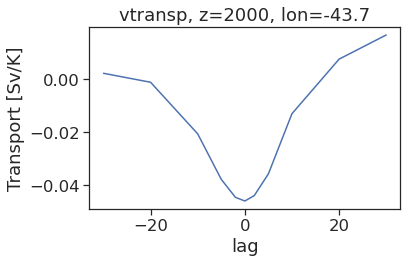

In [51]:
fig1, ax1 = plt.subplots(1,1)
slope_list[-1].sel(depthv=2000,method='nearest').sel(x=488).plot(ax=ax1)
ax1.set_ylabel('Transport [Sv/K]');
ax1.set_title('vtransp, z=2000, lon=%2.1f' % (da_orca05_tlon[360,488],))
fig1.tight_layout()
fig1.savefig('figures/AMOC_vtransp_360-488-2000m_Phase3.pdf',format='pdf')

In [59]:
da_orca05_tlat[360,480:570]

<xarray.DataArray 'gphit' (x: 90)>
array([48.46742 , 48.48691 , 48.50602 , 48.524742, 48.543064, 48.560986,
       48.578495, 48.595585, 48.612247, 48.628483, 48.644276, 48.659626,
       48.674522, 48.68896 , 48.702934, 48.71644 , 48.729465, 48.742012,
       48.754066, 48.76563 , 48.776695, 48.787254, 48.797302, 48.806835,
       48.81585 , 48.82434 , 48.8323  , 48.839725, 48.84661 , 48.852955,
       48.858753, 48.864   , 48.86869 , 48.87282 , 48.876392, 48.8794  ,
       48.881832, 48.883694, 48.88498 , 48.88569 , 48.885815, 48.88536 ,
       48.884315, 48.882683, 48.880463, 48.877647, 48.874237, 48.870228,
       48.865623, 48.86042 , 48.854614, 48.848206, 48.841194, 48.83358 ,
       48.82536 , 48.816536, 48.807106, 48.79707 , 48.786427, 48.775177,
       48.76332 , 48.750862, 48.737797, 48.724125, 48.709854, 48.694977,
       48.6795  , 48.66342 , 48.646744, 48.62947 , 48.6116  , 48.593136,
       48.574078, 48.554432, 48.5342  , 48.51338 , 48.491978, 48.469997,
       48.447437, 48.42431 , 48.400604, 48.376335, 48.3515  , 48.326107,
       48.300156, 48.27365 , 48.246597, 48.219   , 48.190865, 48.162193],
      dtype=float32)
Dimensions without coordinates: x